In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA


from datetime import datetime
import time
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [49]:
df = pd.read_csv("clean.csv")

In [50]:
numerical_feats = ['Months_since_Release', 'Avg_Price_unit']
categorical_feats = ['Format', 'Platform_Label', 'Territory_label']

In [51]:
scaler = StandardScaler()
dummifier = OneHotEncoder()

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', scaler, numerical_feats),
        ('categorical', dummifier, categorical_feats)
    ],
    remainder='passthrough'
)

In [53]:
X = df.drop(columns=['A_units', 'A_values'])  # Drop A_values since it's not known for future data
y = df['A_units']


In [54]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=21)

In [55]:
models = [
    Lasso(),
    RandomForestRegressor(n_estimators=100, random_state=21),
    xgb.XGBRegressor()
    
]

In [56]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [57]:
for model in models:
    start = time.time()
    model.fit(X_train,y_train)
    end = time.time()
    print(type(model).__name__)
    print("")
    print("Time : {:.4f} sec".format(end-start))
    print("Train Score : {:.3f} , Test Score : {:.3f}".format(model.score(X_train,y_train), model.score(X_test,y_test)))
    print("Root mean square error : {:.0f}".format(mean_squared_error(y_test,model.predict(X_test))**(1/2)))
    print(40*"—")

Lasso

Time : 0.0098 sec
Train Score : 0.285 , Test Score : -0.446
Root mean square error : 429
————————————————————————————————————————
RandomForestRegressor

Time : 0.0883 sec
Train Score : 0.883 , Test Score : -1.219
Root mean square error : 532
————————————————————————————————————————
XGBRegressor

Time : 0.0898 sec
Train Score : 1.000 , Test Score : -1.633
Root mean square error : 579
————————————————————————————————————————


In [58]:
LR_parameters = {
    "alpha":[0.001, 0.01, 0.1, 1, 3, 6, 10, 20, 30, 50, 100, 150]
}

In [59]:
RF_parameters = {
    "n_estimators": [50, 100, 200,300],
    "max_depth": [5, 10, 20, 30, 80],
    "min_samples_split": [5,10,20],
    "min_samples_leaf": [1,3, 5, 10]
}

In [60]:
XGB_parameters = {
    'n_estimators': [50, 100, 200,300],
    'max_depth': [1,2,4,10],
    'gamma':[0,0.1,0.2,0.5]

}

In [61]:
param_grids = [LR_parameters, RF_parameters, XGB_parameters]


for model, param_grid in zip(models, param_grids):
    start = time.time()
    warnings.filterwarnings("ignore")

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train)

    end = time.time()

    
    print(type(model).__name__)
    print("Time: {:.4f} sec".format(end - start))
    print('')
    print("Best Parameters:", grid_search.best_params_)
    print("Best R2-Score (r2):", grid_search.best_score_)
    
    best_model = grid_search.best_estimator_

    print("Train Score: {:.3f}, Test Score: {:.3f}".format(
        best_model.score(X_train, y_train), best_model.score(X_test, y_test)))
    
    y_pred = best_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("Root Mean Square Error: {:.0f}".format(rmse))
    
    print(40 * "—")

Lasso
Time: 0.0592 sec

Best Parameters: {'alpha': 50}
Best R2-Score (r2): 0.16639330077947956
Train Score: 0.173, Test Score: 0.170
Root Mean Square Error: 325
————————————————————————————————————————
RandomForestRegressor
Time: 46.6323 sec

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best R2-Score (r2): 0.1389329859261715
Train Score: 0.393, Test Score: 0.040
Root Mean Square Error: 350
————————————————————————————————————————
XGBRegressor
Time: 16.3142 sec

Best Parameters: {'gamma': 0.5, 'max_depth': 4, 'n_estimators': 50}
Best R2-Score (r2): 0.10012985045601981
Train Score: 0.997, Test Score: -0.322
Root Mean Square Error: 410
————————————————————————————————————————


## feature importance using Lasso

In [62]:
categorical_column_names = preprocessor.transformers_[1][1].categories_
numerical_column_names = X.loc[:, numerical_feats].columns
column_names = list(X.columns)
boolean_column_names = [col for col in column_names if X[col].dtype == bool]

In [63]:
all_column_names = []
flat_categorical_column_names = np.concatenate(categorical_column_names)
all_column_names = np.append(flat_categorical_column_names, numerical_column_names)
all_column_names = np.append(all_column_names, boolean_column_names)

In [77]:
regressor = Lasso(alpha=3.0)
regressor.fit(X_train, y_train)
feature_importance_coef = regressor.coef_

In [78]:
feature_importance = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":feature_importance_coef.flatten()
})

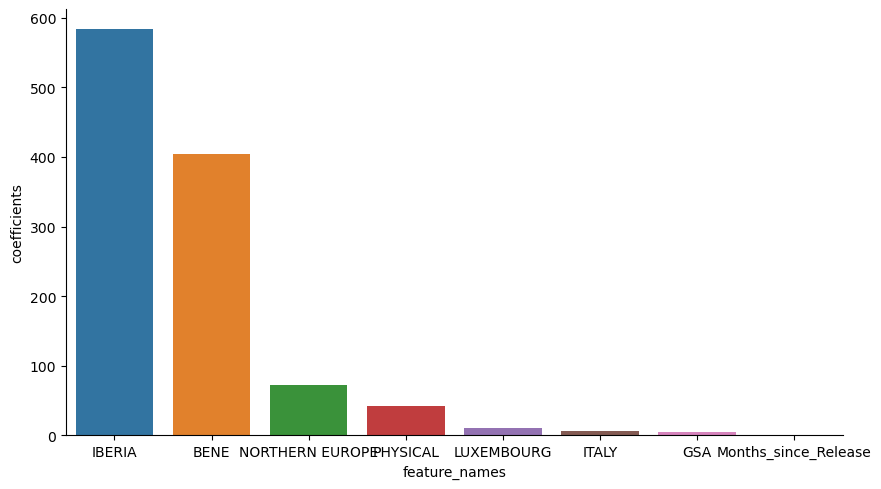

In [79]:
sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance.sort_values(by="coefficients", ascending=False).head(8), 
            kind="bar",
            aspect=16/9)